In [1]:
!pip install sentence-transformers datasets transformers

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.2/255.2 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import re


# read input document
X = pd.read_csv('/content/train_set.csv')
X = X[['feedback', 'label']]


X['feedback'] = X['feedback'].apply(lambda x: x.lower())
X['feedback'] = X['feedback'].apply((lambda x: re.sub('[^a-zA-z0-9\s]', '', x)))


df = pd.read_csv('/content/test_set.csv')
df = df[['feedback', 'label']]

df['feedback'] = df['feedback'].apply(lambda x: x.lower())
df['feedback'] = df['feedback'].apply((lambda x: re.sub('[^a-zA-z0-9\s]', '', x)))



V = pd.read_csv('/content/validation_set.csv')
V = V[['feedback', 'label']]

V['feedback'] = V['feedback'].apply(lambda x: x.lower())
V['feedback'] = V['feedback'].apply((lambda x: re.sub('[^a-zA-z0-9\s]', '', x)))



In [3]:
print("Train Set")
print(X.shape)
print(X['label'].value_counts())

print("Test Set")
print(df.shape)
print(df['label'].value_counts())

print("Validation Set")
print(V.shape)
print(V['label'].value_counts())

print("Concatenated Dataset")
dataset=pd.concat([X,df,V])
print(dataset.shape)

Train Set
(656, 2)
label
0    97
4    88
8    87
3    80
1    72
2    70
5    66
7    65
6    31
Name: count, dtype: int64
Test Set
(225, 2)
label
0    25
1    25
2    25
3    25
4    25
5    25
6    25
7    25
8    25
Name: count, dtype: int64
Validation Set
(116, 2)
label
0    17
4    16
8    16
3    14
1    13
2    12
5    12
7    11
6     5
Name: count, dtype: int64
Concatenated Dataset
(997, 2)


In [4]:

print(dataset['label'].value_counts())
print(dataset.info())
sampled_df = dataset.groupby('label').sample(n=100, random_state=1,replace=True,)

print(sampled_df['label'].value_counts())
print(sampled_df.info())


label
0    139
4    129
8    128
3    119
1    110
2    107
5    103
7    101
6     61
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 997 entries, 0 to 115
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   feedback  997 non-null    object
 1   label     997 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 23.4+ KB
None
label
0    100
1    100
2    100
3    100
4    100
5    100
6    100
7    100
8    100
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 900 entries, 37 to 115
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   feedback  900 non-null    object
 1   label     900 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 21.1+ KB
None


In [5]:
import random
from nltk.corpus import wordnet
import nltk
nltk.download('wordnet')


def synonym_replacement(sentence, n):
    words = sentence.split()
    new_words = words.copy()
    random_word_list = list(set([word for word in words if wordnet.synsets(word)]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(synonyms)
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:  # only replace up to n words
            break

    sentence = ' '.join(new_words)
    return sentence

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            synonyms.add(l.name())
    if word in synonyms:
        synonyms.remove(word)
    return list(synonyms)

def random_insertion(sentence, n):
    words = sentence.split()
    for _ in range(n):
        new_word = get_synonyms(random.choice(words))
        if new_word:
            words.insert(random.randint(0, len(words)), random.choice(new_word))
    return ' '.join(words)

def random_swap(sentence, n):
    words = sentence.split()
    for _ in range(n):
        idx1, idx2 = random.sample(range(len(words)), 2)
        words[idx1], words[idx2] = words[idx2], words[idx1]
    return ' '.join(words)

def random_deletion(sentence, p):
    words = sentence.split()
    if len(words) == 1:  # return if single word
        return sentence

    new_words = []
    for word in words:
        if random.uniform(0, 1) > p:
            new_words.append(word)
    if len(new_words) == 0:  # ensure at least one word remains
        new_words.append(random.choice(words))
    return ' '.join(new_words)

# Example usage:
sentence = "This is a sample sentence for data augmentation."

sentence = "john has not progressed in his position he is continuously late leaves early and takes many breaks throughout the day he calls out at least every other week and its always on fridays his performance has significantly declined my suggestion is he is not suitable for this position"

print("Original Sentence:", sentence)
print("Synonym Replacement:", synonym_replacement(sentence, 10))
print("Random Insertion:", random_insertion(sentence, 10))
print("Random Swap:", random_swap(sentence, 10))
print("Random Deletion:", random_deletion(sentence, 0.4))




[nltk_data] Downloading package wordnet to /root/nltk_data...


Original Sentence: john has not progressed in his position he is continuously late leaves early and takes many breaks throughout the day he calls out at least every other week and its always on fridays his performance has significantly declined my suggestion is he is not suitable for this position
Synonym Replacement: John_the_Evangelist has not progressed IN his position atomic_number_2 is endlessly late leaves too_soon and takes many breaks throughout the day atomic_number_2 calls out atomic_number_85 least every other week and IT forever on Fri his performance has significantly declined my suggestion is atomic_number_2 is not worthy for this position
Random Insertion: john has not progressed in his position he is continuously late leaves early and belatedly takes many breaks throughout the day progress he move_on unceasingly calls out at least every other week and its endlessly always on fridays At his performance atomic_number_49 has significantly declined my suggestion is he is no

In [6]:
import numpy as np
# Original data
original_sentences = list(sampled_df['feedback'].values)
original_labels = list(sampled_df['label'].values)

# Augmented data
augmented_sentences = []
for sentence in original_sentences:
    augmented_sentences.append(synonym_replacement(sentence, 10))
    augmented_sentences.append(random_insertion(sentence, 10))
    augmented_sentences.append(random_swap(sentence, 10))
    augmented_sentences.append(random_deletion(sentence, 0.3))

# Combine original and augmented data
all_sentences = original_sentences + augmented_sentences

# Repeat labels for the augmented sentences
augmented_labels = np.repeat(original_labels, 4)  # assuming each sentence generates 4 augmented versions
all_labels = np.concatenate((original_labels, augmented_labels))

print(len(all_sentences),len(all_labels))

4500 4500


In [7]:
m=0
for i in all_sentences:
  m=max(m,len(i.split()))
print("Maximum Words",m)

Maximum Words 134


In [8]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(all_sentences,all_labels,test_size=0.8,random_state=50)

In [9]:
print("Training Samples",len(x_train))
print("Testing Samples",len(x_test))

Training Samples 900
Testing Samples 3600


In [10]:
x_train[:5],y_train[:5]

(['good burke is an important on as he team works he at a he pace with good results joseph is future finishing his task member our time will have in as always a the company good long of he works hard',
  'brantley whitfield is an employee that could be going places when working with him i get a sense that he really grasps what we are trying to do with the company his work output may not show it today as it currently doest match the required quality level but i feel like he has really untapped potential we need to brainstorm ways to get him more interested and involved',
  'bethany cunningham has been perfecting her accomplishment as a team_up thespian her tasks have been accomplished with optimal accomplishment at the present meter we constitute hop to parent her natural_endowment promote so far she has shown she has the continued resilience needed',
  'regan rhodes deliver shew their work to be exemplary though we greatly revel the rhodes puts proscribed we feel there could be more of

In [11]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [12]:
from datasets import Dataset
train_df = pd.DataFrame({'text': x_train, 'label': y_train})
train_dataset = Dataset.from_pandas(train_df)
test_df = pd.DataFrame({'text': x_test, 'label': y_test})
test_dataset = Dataset.from_pandas(test_df)

In [13]:
id2label = {
      0: "Risk (Low performance, Low potential)",
      1: "Average performer (Moderate performance, Low potential)",
      2: "Solid Performer (High performance, Low potential)",
      3: "Inconsistent Player (Low performance, Moderate potential)",
      4: "Core Player (Moderate performance, Moderate potential)",
      5: "High Performer (High performance, Moderate potential)",
      6: "Potential Gem (Low performance, High potential)",
      7: "High Potential (Moderate performance, High potential)",
      8: "Star (High performance, High potential)"
            }
label2id = {
      "Risk (Low performance, Low potential)":0,
      "Average performer (Moderate performance, Low potential)":1,
      "Solid Performer (High performance, Low potential)":2,
      "Inconsistent Player (Low performance, Moderate potential)":3,
      "Core Player (Moderate performance, Moderate potential)":4,
      "High Performer (High performance, Moderate potential)":5,
      "Potential Gem (Low performance, High potential)":6,
      "High Potential (Moderate performance, High potential)":7,
      "Star (High performance, High potential)":8
}

In [14]:
from transformers import TFAutoModelForSequenceClassification,AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

model = TFAutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=9, id2label=id2label, label2id=label2id
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [15]:
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

In [16]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [17]:
from transformers import create_optimizer
import tensorflow as tf

batch_size = 16
num_epochs = 5
batches_per_epoch = len(tokenized_train) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

In [18]:
tf_train_set = model.prepare_tf_dataset(
    tokenized_train,
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)


tf_test_set = model.prepare_tf_dataset(
    tokenized_test,
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

In [19]:
import tensorflow as tf

model.compile(optimizer=optimizer,metrics=['accuracy'])  # No loss argument!

In [20]:
history=model.fit(x=tf_train_set, validation_data=tf_test_set, epochs=10)

Epoch 1/10
56/56 [==============================] - 52s 525ms/step - loss: 2.1768 - accuracy: 0.1708 - val_loss: 2.1129 - val_accuracy: 0.2225
Epoch 2/10
56/56 [==============================] - 31s 562ms/step - loss: 1.9240 - accuracy: 0.3672 - val_loss: 1.8106 - val_accuracy: 0.4167
Epoch 3/10
56/56 [==============================] - 31s 555ms/step - loss: 1.6109 - accuracy: 0.5402 - val_loss: 1.6024 - val_accuracy: 0.5144
Epoch 4/10
56/56 [==============================] - 31s 561ms/step - loss: 1.3776 - accuracy: 0.6719 - val_loss: 1.4876 - val_accuracy: 0.5219
Epoch 5/10
56/56 [==============================] - 31s 561ms/step - loss: 1.2429 - accuracy: 0.7243 - val_loss: 1.4238 - val_accuracy: 0.5658
Epoch 6/10
56/56 [==============================] - 26s 467ms/step - loss: 1.2088 - accuracy: 0.7366 - val_loss: 1.4238 - val_accuracy: 0.5658
Epoch 7/10
56/56 [==============================] - 31s 564ms/step - loss: 1.2117 - accuracy: 0.7310 - val_loss: 1.4238 - val_accuracy: 0.5658

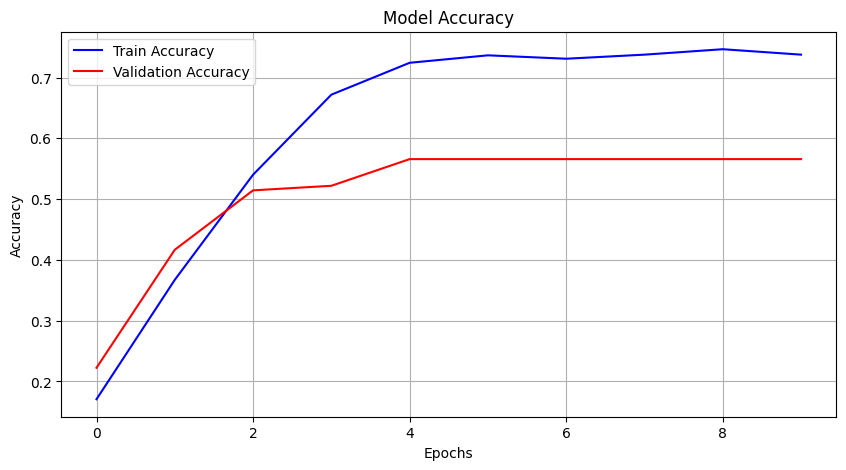

In [21]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(10, 5))

# Plot training accuracy
plt.plot(history.history['accuracy'], color='b', label='Train Accuracy')

# Plot validation accuracy
plt.plot(history.history['val_accuracy'], color='r', label='Validation Accuracy')

# Plot customization
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='best')
plt.grid()

# Show the plot
plt.show()


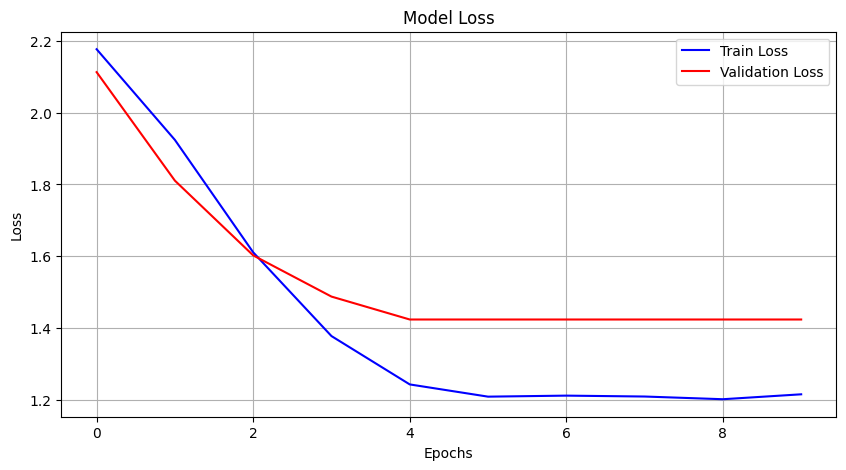

In [22]:
# Plot Loss
plt.figure(figsize=(10, 5))

# Plot training loss
plt.plot(history.history['loss'], color='b', label='Train Loss')

# Plot validation loss
plt.plot(history.history['val_loss'], color='r', label='Validation Loss')

# Plot customization
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='best')
plt.grid()

# Show the plot
plt.show()
